In [1]:
# https://www.kaggle.com/code/fagbamigbekehinde/twitter-sentiment-analysis

## importing dependencies

In [1]:
# utilities
import re
import pickle
import numpy as np
import pandas as pd

# plotting
import seaborn as sns
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Natural Language Toolkit (nltk)
from nltk.stem import WordNetLemmatizer
from nltk import download
download('stopwords')
download('wordnet')
from nltk.corpus import stopwords
import nltk
nltk.download('omw-1.4')

# Model Buildig (sklearn)
from sklearn.svm import LinearSVC
from sklearn.naive_bayes import BernoulliNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

#Data Splitting and Traininig
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report

import time

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


In [22]:
import nltk
nltk.download('omw-1.4')

[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\omw-1.4.zip.


True

## import the dataset

In [10]:
encoding_used = "ISO-8859-1"
data_columns  = ["target", "ids", "date", "flag", "user", "text"]
tweets_df = pd.read_csv("training.1600000.processed.noemoticon.csv", encoding=encoding_used, names=data_columns)
tweets_df.head()

,target,ids,date,flag,user,text
0,0,1467810369,Mon Apr 06 22:19:45 PDT 2009,NO_QUERY,_TheSpecialOne_,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,1467810672,Mon Apr 06 22:19:49 PDT 2009,NO_QUERY,scotthamilton,is upset that he can't update his Facebook by ...
2,0,1467810917,Mon Apr 06 22:19:53 PDT 2009,NO_QUERY,mattycus,@Kenichan I dived many times for the ball. Man...
3,0,1467811184,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,ElleCTF,my whole body feels itchy and like its on fire
4,0,1467811193,Mon Apr 06 22:19:57 PDT 2009,NO_QUERY,Karoli,"@nationwideclass no, it's not behaving at all...."


## EDA

In [11]:
target_group = tweets_df.groupby('target').count()['text']
target_group

target
0    800000
4    800000
Name: text, dtype: int64

## slicing only needed data

In [14]:
data = tweets_df[['target', 'text']]
data.columns = ["sentiment", "text"] # renaming columns
data['sentiment'] = data['sentiment'].replace(4,1) # replacing positive sentiment (4 with 1)
data.head()

C:\Users\user\AppData\Local\Temp/ipykernel_2540/192324151.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data['sentiment'] = data['sentiment'].replace(4,1) # replacing positive sentiment (4 with 1)


,sentiment,text
0,0,"@switchfoot http://twitpic.com/2y1zl - Awww, t..."
1,0,is upset that he can't update his Facebook by ...
2,0,@Kenichan I dived many times for the ball. Man...
3,0,my whole body feels itchy and like its on fire
4,0,"@nationwideclass no, it's not behaving at all...."


In [15]:
data[data['sentiment'] != 0].head()

,sentiment,text
800000,1,I LOVE @Health4UandPets u guys r the best!!
800001,1,im meeting up with one of my besties tonight! ...
800002,1,"@DaRealSunisaKim Thanks for the Twitter add, S..."
800003,1,Being sick can be really cheap when it hurts t...
800004,1,@LovesBrooklyn2 he has that effect on everyone


In [16]:
# converts data to list form
text, sentiment = list(data['text']), list(data['sentiment'])

## preprocessing

In [11]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}

mystopwordlist = ['a', 'about', 'above', 'after', 'again', 'ain', 'all', 'am', 'an',
             'and','any','are', 'as', 'at', 'be', 'because', 'been', 'before',
             'being', 'below', 'between','both', 'by', 'can', 'd', 'did', 'do',
             'does', 'doing', 'down', 'during', 'each','few', 'for', 'from', 
             'further', 'had', 'has', 'have', 'having', 'he', 'her', 'here',
             'hers', 'herself', 'him', 'himself', 'his', 'how', 'i', 'if', 'in',
             'into','is', 'it', 'its', 'itself', 'just', 'll', 'm', 'ma',
             'me', 'more', 'most','my', 'myself', 'now', 'o', 'of', 'on', 'once',
             'only', 'or', 'other', 'our', 'ours','ourselves', 'out', 'own', 're',
             's', 'same', 'she', "shes", 'should', "shouldve",'so', 'some', 'such',
             't', 'than', 'that', "thatll", 'the', 'their', 'theirs', 'them',
             'themselves', 'then', 'there', 'these', 'they', 'this', 'those', 
             'through', 'to', 'too','under', 'until', 'up', 've', 'very', 'was',
             'we', 'were', 'what', 'when', 'where','which','while', 'who', 'whom',
             'why', 'will', 'with', 'won', 'y', 'you', "youd","youll", "youre",
             "youve", 'your', 'yours', 'yourself', 'yourselves']

stopwordlist = stopwords.words('english') + mystopwordlist

In [12]:
def preprocess(textdata):
    processedText = []
    
    #creating a Lemmatizer
    wordLemma = WordNetLemmatizer() #define the imported library
    
    # Defining regular expression pattern we can find. in tweets
    
    urlPattern        = r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)" # e.g check out https://dot.com for more
    userPattern       = '@[^\s]+' # e.g @FagbamigbeK check this out
    alphaPattern      = "[^a-zA-Z0-9]" # e.g I am *10 better!
    sequencePattern   = r"(.)\1\1+"  # e.g Heyyyyyyy, I am back!
    seqReplacePattern = r"\1\1" # e.g Replace Heyyyyyyy with Heyy
    
    
    for tweet in textdata:
        tweet = tweet.lower() #normalizing all text to a lower case
        
        
        # Replace all URls with 'URL'
        tweet = re.sub(urlPattern,' URL',tweet) #using the substitution method of the regular expression library
        
        
        # Replace all emojis.
        for emoji in emojis.keys(): #in each of the looped tweet, replace each emojis with their respective meaning
            tweet = tweet.replace(emoji, "EMOJI" + emojis[emoji])  # emojis[emoji] helps to get the value of the emoji from the dictionary
            
            
        # Replace @USERNAME to 'USER'.
        tweet = re.sub(userPattern,' USER', tweet)  #To hide Personal Information, we can replace all usernames with User
        
        
        # Replace all non alphabets.
        tweet = re.sub(alphaPattern, " ", tweet) # e.g I am *10 better!
        
        
        # Replace 3 or more consecutive letters by 2 letter.
        tweet = re.sub(sequencePattern, seqReplacePattern, tweet) # e.g Replace Heyyyyyyy with Heyy
        
        
        tweetwords = ''
        for word in tweet.split():
            if len(word) > 2 and word.isalpha():
                word = wordLemma.lemmatize(word)
                tweetwords += (word + ' ')
        
        processedText.append(tweetwords)
        
    return processedText

In [23]:
t = time.time()
preprocessedtext = preprocess(text) #the preprocess function at work
print(f'Text Processing Done.')
print(f'Time taken for text processing: {round(time.time()-t)} seconds')

Text Processing Done.
Time taken for text processing: 173 seconds


## before preprocessing

In [24]:
text[0:11]

["@switchfoot http://twitpic.com/2y1zl - Awww, that's a bummer.  You shoulda got David Carr of Third Day to do it. ;D",
 "is upset that he can't update his Facebook by texting it... and might cry as a result  School today also. Blah!",
 '@Kenichan I dived many times for the ball. Managed to save 50%  The rest go out of bounds',
 'my whole body feels itchy and like its on fire ',
 "@nationwideclass no, it's not behaving at all. i'm mad. why am i here? because I can't see you all over there. ",
 '@Kwesidei not the whole crew ',
 'Need a hug ',
 "@LOLTrish hey  long time no see! Yes.. Rains a bit ,only a bit  LOL , I'm fine thanks , how's you ?",
 "@Tatiana_K nope they didn't have it ",
 '@twittera que me muera ? ',
 "spring break in plain city... it's snowing "]

## after preprocessing

In [25]:
preprocessedtext[0:11]

['USER URL aww that bummer you shoulda got david carr third day EMOJIwink ',
 'upset that can update his facebook texting and might cry result school today also blah ',
 'USER dived many time for the ball managed save the rest out bound ',
 'whole body feel itchy and like it fire ',
 'USER not behaving all mad why here because can see you all over there ',
 'USER not the whole crew ',
 'need hug ',
 'USER hey long time see yes rain bit only bit lol fine thanks how you ',
 'USER nope they didn have ',
 'USER que muera ',
 'spring break plain city snowing ']

## negative word cloud

In [26]:
negative_sentiments = preprocessedtext[:800000]
data_neg = []
for words in negative_sentiments:
    words = words.lower().replace("user","")
    words = words.lower().replace("url","")
    data_neg.append(words)
    
data_neg[0:10]

['  aww that bummer you shoulda got david carr third day emojiwink ',
 'upset that can update his facebook texting and might cry result school today also blah ',
 ' dived many time for the ball managed save the rest out bound ',
 'whole body feel itchy and like it fire ',
 ' not behaving all mad why here because can see you all over there ',
 ' not the whole crew ',
 'need hug ',
 ' hey long time see yes rain bit only bit lol fine thanks how you ',
 ' nope they didn have ',
 ' que muera ']

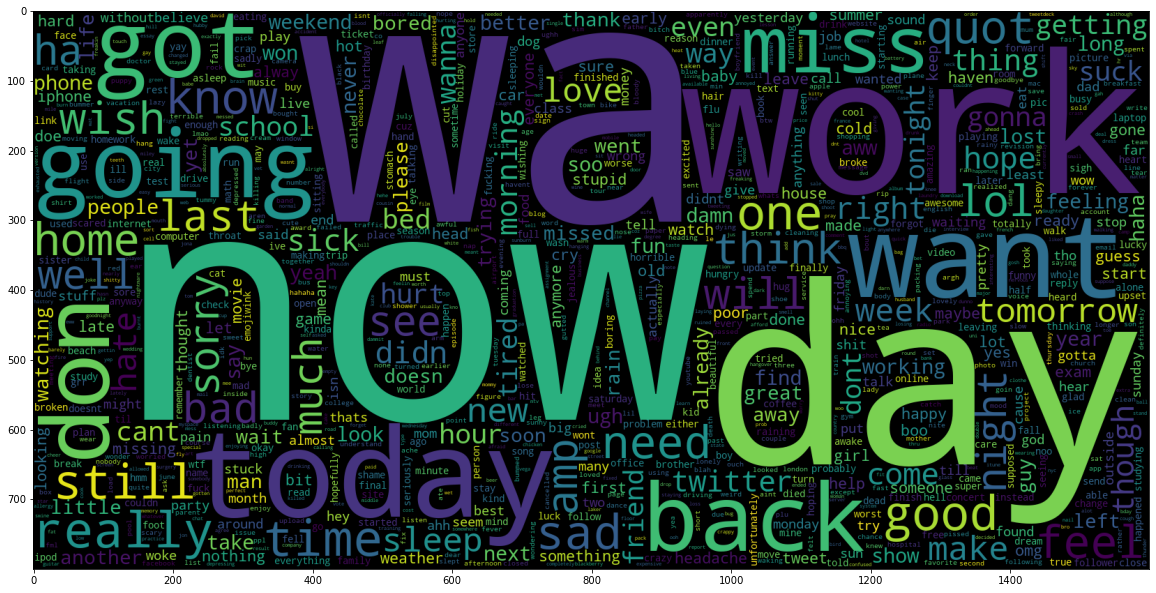

In [27]:
word_cloud = WordCloud(max_words = 1000 , width = 1600 , height = 800, collocations=False)
plt.figure(figsize = (20,20))
negative_wc = word_cloud.generate(" ".join(data_neg))
plt.imshow(negative_wc)

## positive word cloud

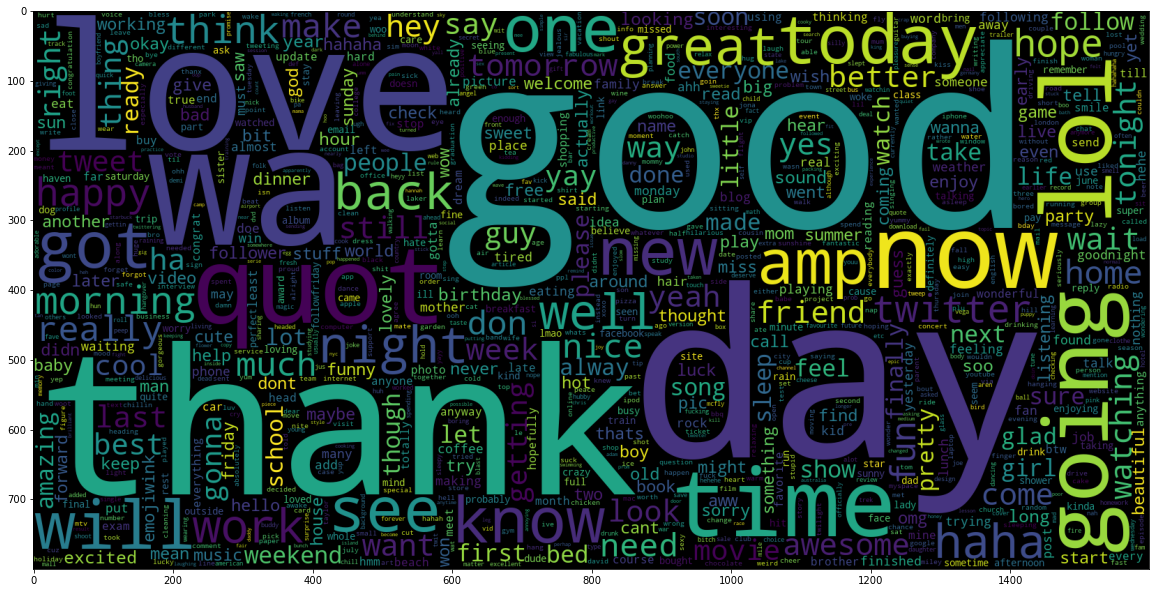

In [28]:
positive_sentiments = preprocessedtext[800000:]
data_pos = []
for words in positive_sentiments:
    words = words.lower().replace("user","")
    words = words.lower().replace("url","")
    data_pos.append(words)
    
plt.figure(figsize = (20,20))
positive_wc = word_cloud.generate(" ".join(data_pos))
plt.imshow(positive_wc)

## transform dataset using tf-idf vectoriser

In [29]:
# split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(preprocessedtext, sentiment,
                                                    test_size = 0.05, random_state = 0)
print(f'Data Split done.')

Data Split done.


In [30]:
vectoriser = TfidfVectorizer(ngram_range=(1,2),stop_words = stopwordlist, strip_accents = 'unicode', max_features = 500000)
vectoriser.fit(X_train) #fit the training data
print(f'Vectoriser fitted.')
print('No. of feature_words: ', len(vectoriser.get_feature_names()))

Vectoriser fitted.
No. of feature_words:  500000


In [31]:
#transform the training and test data
X_train = vectoriser.transform(X_train)
X_test  = vectoriser.transform(X_test)
print(f'Data Transformed.')

Data Transformed.


# Models

## model evaluation function

In [32]:
def model_Evaluate(model):
    
    # Predict values for Test dataset
    y_pred = model.predict(X_test) #Xtest is not used in model training

    # Print the evaluation metrics for the dataset.
    print(classification_report(y_test, y_pred))
    
    # Compute and plot the Confusion matrix
    cf_matrix = confusion_matrix(y_test, y_pred)

    categories  = ['Negative','Positive']
    group_names = ['True Neg','False Pos', 'False Neg','True Pos'] #configuration of a confusin matrix
    group_percentages = ['{0:.2%}'.format(value) for value in cf_matrix.flatten() / np.sum(cf_matrix)] #converting confusion matrix value to percentage in 2 decimal places.

    labels = [f'{v1}\n{v2}' for v1, v2 in zip(group_names,group_percentages)]
    labels = np.asarray(labels).reshape(2,2)

    sns.heatmap(cf_matrix, annot = labels, cmap = 'Blues',fmt = '',
                xticklabels = categories, yticklabels = categories)

    plt.xlabel("Predicted values", fontdict = {'size':14}, labelpad = 10)
    plt.ylabel("Actual values"   , fontdict = {'size':14}, labelpad = 10)
    plt.title ("Confusion Matrix", fontdict = {'size':18}, pad = 20)

              precision    recall  f1-score   support

           0       0.81      0.78      0.79     39989
           1       0.79      0.81      0.80     40011

    accuracy                           0.80     80000
   macro avg       0.80      0.80      0.80     80000
weighted avg       0.80      0.80      0.80     80000



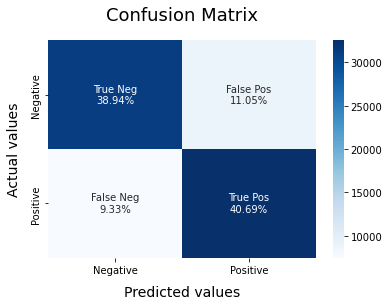

In [33]:
LRmodel = LogisticRegression(C = 2, max_iter = 1000, n_jobs=-1)
LRmodel.fit(X_train, y_train)
model_Evaluate(LRmodel)

## Saving the model

In [34]:
#Linear Regression
file = open('Sentiment-LR.pickle','wb')
pickle.dump(LRmodel, file)
file.close()

In [35]:
#Vectoriser
file = open('vectoriser-ngram-(1,2).pickle','wb')
pickle.dump(vectoriser, file)
file.close()

## Using the model

In [14]:
def load_models():
    '''
    Replace '..path/' by the path of the saved models.
    '''
    
    # Load the vectoriser.
    file = open('vectoriser-ngram-(1,2).pickle', 'rb')
    vectoriser = pickle.load(file)
    file.close()
    
    
    # Load the LR Model.
    file = open('Sentiment-LR.pickle', 'rb')
    LRmodel = pickle.load(file)
    file.close()
    
    return vectoriser, LRmodel

def predict(vectoriser, model, text):
    # Predict the sentiment
    textdata = vectoriser.transform(preprocess(text)) #Passing the tweet through the processing stage and transforming it with the vectoriser
    sentiment = model.predict(textdata)
    
    print(model.predict_proba(textdata))
    
    # Make a list of text with sentiment.
    data = []
    for text, pred in zip(text, sentiment):
        data.append((text,pred))
        
    # Convert the list into a Pandas DataFrame.
    df = pd.DataFrame(data, columns = ['text','sentiment'])
    df = df.replace([0,1], ["Negative","Positive"]) #Replacing the class of 0 and 1 with Negative and Positive respectively
    return df

In [15]:
if __name__=="__main__":
    # Loading the models.
    vectoriser, LRmodel = load_models()
    
    # Text to classify should be in a list.
    text = ["I Love Google!",
            "May the Good Lord be with you.", "I hate peanuts!",
            "Mr. Kehinde, what are you doing next? this is great!"]
    
    df = predict(vectoriser, LRmodel, text)
    print(df.head())

[[0.04445976 0.95554024]
 [0.33367797 0.66632203]
 [0.98807497 0.01192503]
 [0.16033909 0.83966091]]
                                                text sentiment
0                                     I Love Google!  Positive
1                     May the Good Lord be with you.  Positive
2                                    I hate peanuts!  Negative
3  Mr. Kehinde, what are you doing next? this is ...  Positive
